# Imports

In [1]:
import re
import glob
import functools
import os
import gzip
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20, 10)

In [2]:
'dropoffs_barclays_center_0.003.csv.gz'[len('dropoffs_'):-len('_0.003.csv.gz')].replace('_', ' ')

'barclays center'

In [3]:
def venue_name(file):
    return os.path.basename(file)[len('dropoffs_'):-len('_0.003.csv.gz')].replace('_', ' ')

def for_d3(file):
    idx = pd.Series(0, index=pd.date_range('2016-01-01', '2016-09-01', freq='H'), name='all_ts')\
        .asfreq('30Min', method='pad')
    df = pd.read_csv(gzip.open(file), delimiter=',')\
        .assign(minute=lambda df: df.minute * 30)\
        .assign(time=lambda df: df.date.astype(str) + ' ' + df.hour.astype(str).str.zfill(2) + ':' + df.minute.astype(str).str.zfill(2))\
        [['time', 'dropoffs']]\
        .set_index('time')
    return df\
        .join(idx, how='right')\
        .fillna(0)\
        [lambda df2: df2.index <= df.index.max()]\
        .reset_index()\
        .rename(columns={'index': 'time'})\
        .assign(dropoffs=lambda df: df.dropoffs.astype(int))\
        .drop('all_ts', axis=1)\
        .assign(venue=venue_name(file))

In [5]:
def for_d3_hourly(f):
    return for_d3(f)\
        .assign(date=lambda df: df.time.dt.date)\
        .assign(hour=lambda df: df.time.dt.hour)\
        .groupby(['date', 'hour'])\
        .sum()\
        .reset_index()\
        .assign(venue=venue_name(f))

for_d3_hourly(os.path.join('data', 'dropoffs_bowery_ballroom_0.003.csv.gz')).head()

,date,hour,dropoffs,venue
0,2016-01-01,0,166,bowery ballroom
1,2016-01-01,1,215,bowery ballroom
2,2016-01-01,2,180,bowery ballroom
3,2016-01-01,3,124,bowery ballroom
4,2016-01-01,4,105,bowery ballroom


In [6]:
def dropoffs_all():
    df_all = None
    for f in glob.glob(os.path.join('data', 'dropoffs*0.003.csv.gz')):
        if df_all is None:
            df_all = for_d3_hourly(f)
        else:
            df_all = pd.concat([df_all, for_d3_hourly(f)])
    df_all.to_csv(os.path.join('for_d3', 'dropoffs_time_series_hourly.csv'), index=False)

dropoffs_all()

In [7]:
def yearly_stats_for_d3(file):
    df = for_d3(file)
    return df.mean()[0], (df.dropoffs.min() - df.mean())[0], (df.dropoffs.max() - df.mean())[0]

In [8]:
yearly_stats_for_d3(os.path.join('data', 'dropoffs_bowery_ballroom_0.003.csv.gz'))

(45.91162737729188, -45.91162737729188, 204.0883726227081)

In [9]:
def all_venues_yearly_stats():
    with open(os.path.join('for_d3', 'overall_mean_dropoffs.csv'), 'w') as f_out:
        f_out.write('venue,mean,min_below,max_above\n')
        for f in glob.glob(os.path.join('data', 'dropoffs*0.003.csv.gz')):
            stats = yearly_stats_for_d3(f)
            f_out.write(venue_name(f) + ',' + ','.join(str(e) for e in stats) + '\n')
            
all_venues_yearly_stats()

In [10]:
def all_venues_hourly_stats():
    with open(os.path.join('for_d3', 'hourly_mean_dropoffs.csv'), 'w') as f_out:
        f_out.write('venue,' + ','.join(str(i) for i in range(24)) + '\n')
        for f in glob.glob(os.path.join('data', 'dropoffs*0.003.csv.gz')):
            hourly_mean = for_d3(f).assign(hour=lambda df: df.time.dt.hour).groupby('hour').mean()
            f_out.write(venue_name(f) + ',' + ','.join(str(e) for e in list(hourly_mean.dropoffs)) + '\n')
            
all_venues_hourly_stats()

In [11]:
list(for_d3(os.path.join('data', 'dropoffs_bowery_ballroom_0.003.csv.gz')).assign(hour=lambda df: df.time.dt.hour).groupby('hour').mean().dropoffs)

[80.48633879781421,
 60.53005464480874,
 41.333333333333336,
 26.136612021857925,
 15.079234972677595,
 6.409836065573771,
 6.060109289617486,
 9.592896174863387,
 13.415300546448087,
 22.10928961748634,
 30.404371584699454,
 36.666666666666664,
 43.177595628415304,
 42.20765027322405,
 39.84699453551912,
 37.69945355191257,
 35.17486338797814,
 45.01092896174863,
 72.77595628415301,
 90.96994535519126,
 91.18032786885246,
 87.60109289617486,
 82.62465753424658,
 85.7032967032967]

In [12]:
def all_venues_yearly_stats():
    with open(os.path.join('for_d3', 'mean_dropoffs.csv'), 'w') as f_out:
        f_out.write('venue,mean,min_below,max_above\n')
        for f in glob.glob(os.path.join('data', 'dropoffs*0.003.csv.gz')):
            stats = yearly_stats_for_d3(f)
            f_out.write(venue_name(f) + ',' + ','.join(str(e) for e in stats) + '\n')
            
all_venues_yearly_stats()

In [13]:
for_d3(os.path.join('data', 'dropoffs_bowery_ballroom_0.003.csv.gz')).head()

,time,dropoffs,venue
0,2016-01-01 00:00:00,72,bowery ballroom
1,2016-01-01 00:30:00,94,bowery ballroom
2,2016-01-01 01:00:00,106,bowery ballroom
3,2016-01-01 01:30:00,109,bowery ballroom
4,2016-01-01 02:00:00,90,bowery ballroom


In [14]:
d_for_plot = for_d3(os.path.join('data', 'dropoffs_bowery_ballroom_0.003.csv.gz')).set_index('time')
#     [lambda df: df.time <= '2016-03-07']\
#     [lambda df: df.time >= '2016-03-01']\


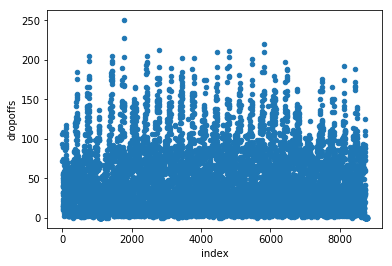

In [15]:
d_for_plot.reset_index().reset_index().plot.scatter(x='index', y='dropoffs')

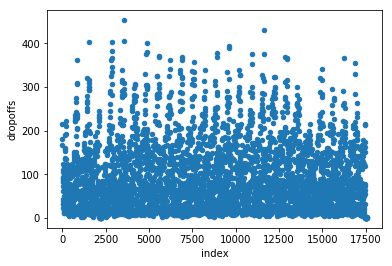

In [16]:
d_for_plot.reset_index().reset_index().assign(date=lambda df: df.time.dt.date)\
    .assign(hour=lambda df: df.time.dt.hour)\
    .drop(['time', 'venue'], axis=1)\
    .groupby(['date', 'hour'])\
    .sum().plot.scatter(x='index', y='dropoffs')

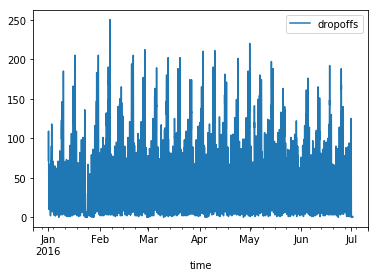

In [17]:
d_for_plot.plot()

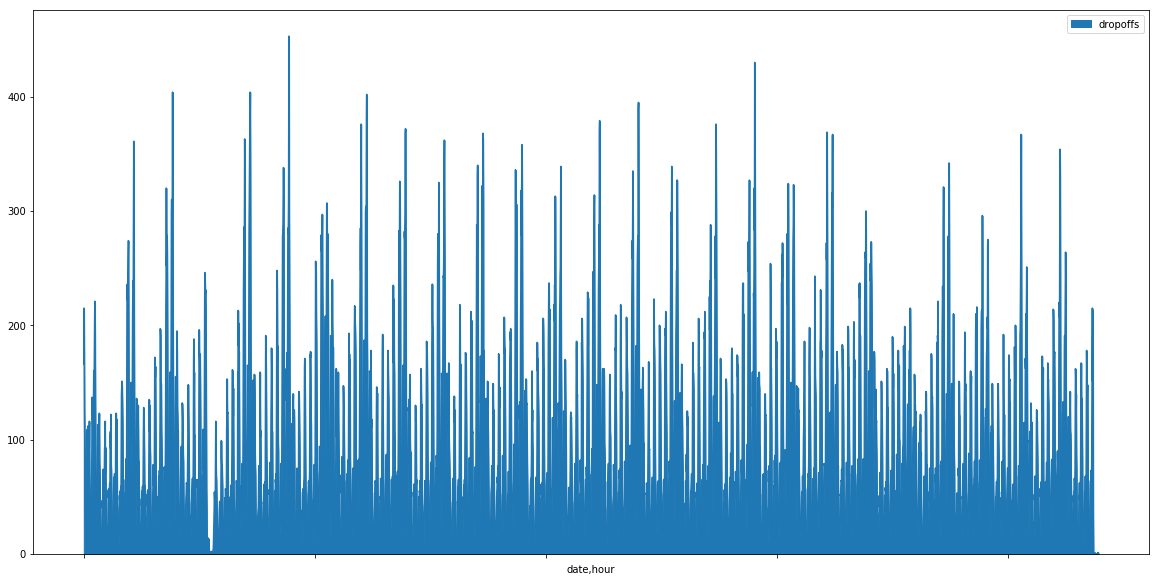

In [197]:
for_d3(os.path.join('data', 'dropoffs_bowery_ballroom_0.003.csv.gz'))\
    .assign(date=lambda df: df.time.dt.date)\
    .assign(hour=lambda df: df.time.dt.hour)\
    .drop(['time', 'venue'], axis=1)\
    .groupby(['date', 'hour'])\
    .sum().plot.area()

In [66]:
def historical_average_day_and_hour(f):
    return for_d3(f)\
        .assign(date=lambda df: df.time.dt.date)\
        .assign(hour=lambda df: df.time.dt.hour)\
        .groupby(['date', 'hour']).sum()\
        .reset_index()\
        .assign(date=lambda df: pd.to_datetime(df.date))\
        .assign(weekday=lambda df: df.date.dt.weekday)\
        .groupby(['weekday', 'hour'])\
        .agg(['mean', 'std'])\
        .reset_index()\
        .assign(weekday=lambda df: (df.weekday + 1) % 7)

In [67]:
historical_average_day_and_hour(os.path.join('data', 'dropoffs_bowery_ballroom_0.003.csv.gz')).head()

weekday hour   dropoffs           
                     mean        std
0       1    0  64.153846  27.742664
1       1    1  40.576923  24.285260
2       1    2  23.923077  13.902296
3       1    3  15.384615   8.509181
4       1    4  12.653846   4.344581

In [71]:
def all_venues_historical():
    df_all = None
    for f in glob.glob(os.path.join('data', 'dropoffs*0.003.csv.gz')):
        df_venue = historical_average_day_and_hour(f).assign(venue=venue_name(f))
        df_all = df_venue if df_all is None else pd.concat([df_all, df_venue])
    return df_all
            
df_tmp = all_venues_historical()

In [73]:
df_tmp.head()

weekday hour   dropoffs                     venue
                     mean        std               
0       1    0  73.363636  46.340329  the town hall
1       1    1  38.031250  25.441247  the town hall
2       1    2  25.031250  16.493370  the town hall
3       1    3  17.062500  11.207536  the town hall
4       1    4  22.937500  13.457070  the town hall

In [105]:
d = {}
for v in set(df_tmp.venue):
    d[v] = {}
    dv = df_tmp[df_tmp.venue == v]
    for w in set(dv.weekday):
        dvw = dv[dv.weekday == w]
        d[v][w] = {}
        for h in range(24):
            d[v][w][h] = {
                'mean': float(dvw[dvw.hour == h].dropoffs['mean']),
                'std': float(dvw[dvw.hour == h].dropoffs['std'])
            }
        

In [108]:
import json
open(os.path.join('for_d3', 'mean_and_std_dropoffs.json'), 'w').write(json.dumps(d))

131395

In [60]:
# pd.read_csv(gzip.open(os.path.join('data', 'dropoffs_beacon_theatre_0.003.csv.gz')), delimiter=',')\
#     .assign(minute=lambda df: df.minute * 30)\
#     .assign(time=lambda df: df.date.astype(str) + ' ' + df.hour.astype(str).str.zfill(2) + ':' + df.minute.astype(str).str.zfill(2))\
#     [['time', 'dropoffs']]\
#     [lambda df: df.time.str[11:13] == '04']

# for_d3(os.path.join('data', 'dropoffs_beacon_theatre_0.003.csv.gz'))\
#     .assign(date=lambda df: df.time.dt.date)\
#     .assign(hour=lambda df: df.time.dt.hour)\
#     .groupby(['date', 'hour']).sum()\
#     .reset_index()\
#     .assign(date=lambda df: pd.to_datetime(df.date))\
#     .assign(weekday=lambda df: df.date.dt.weekday)\
#     .groupby(['weekday', 'hour'])\
#     .agg(['mean', 'std'])

dropoffs           
                    mean        std
weekday hour                       
0       0      66.615385  17.636501
        1      32.423077  10.477301
        2      17.346154   8.108969
        3      12.000000   6.125357
        4      10.192308   2.785954
        5      21.153846   5.619198
        6      46.269231   8.865924
        7      89.269231  18.098746
        8     141.153846  40.256868
        9     148.230769  31.678772
        10    150.615385  19.118738
        11    173.500000  24.493673
        12    193.576923  28.529526
        13    189.192308  28.806970
        14    217.346154  31.183255
        15    263.807692  65.959393
        16    245.230769  32.010383
        17    265.576923  35.729174
        18    318.384615  41.716258
        19    301.346154  48.276655
        20    242.769231  35.832173
        21    225.538462  31.880064
        22    188.884615  28.117364
        23    121.230769  19.738911
1       0      73.692308  16.081714
        1      35.384615   9.029183
        2      17.961538   5.203697
        3      10.961538   3.831248
        4       9.576923   2.802471
        5      22.730769   5.407829
...                  ...        ...
5       18    268.884615  73.761956
        19    269.884615  79.567494
        20    214.500000  55.865732
        21    199.846154  55.102590
        22    211.307692  51.702046
        23    204.423077  51.163403
6       0     172.846154  44.160337
        1     136.653846  35.894225
        2      97.807692  31.780521
        3      69.000000  19.187496
        4      43.961538  13.938381
        5      17.923077   7.662496
        6      24.730769   7.592405
        7      53.538462  17.399381
        8     107.730769  26.432643
        9     169.269231  41.004934
        10    223.923077  49.562020
        11    249.923077  51.271765
        12    252.000000  44.757122
        13    241.923077  45.305119
        14    231.769231  38.172564
        15    242.307692  41.851900
        16    250.192308  50.995701
        17    240.038462  37.845455
        18    253.500000  42.393632
        19    224.038462  51.863267
        20    173.730769  26.554936
        21    163.269231  26.945215
        22    142.615385  27.833903
        23    103.576923  23.404569

[168 rows x 2 columns]